In [1]:
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from utils2 import *
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import random
from network import *
from generate import *

In [ ]:
def load_augmented_data():
    """Load the previously augmented dataset"""
    
    path = './data/scales_note_join_augmented.pkl'  # Original pipeline output
    
    try:
        with open(path, 'rb') as file:
            midi_data = pickle.load(file, encoding="latin1")
        print(f"Loaded {path}")
        break
    except FileNotFoundError:
        print(f"File not found: {path}")
        continue

    
    print(f"Dataset splits:")
    print(f"  Train: {len(midi_data['train'])} songs")
    print(f"  Test: {len(midi_data['test'])} songs") 
    print(f"  Valid: {len(midi_data['valid'])} songs")
    
    return midi_data

midi_data = load_augmented_data()

sample_song = midi_data['train'][0]
print(f"\nSample song structure:")
print(f"  Length: {len(sample_song)} time steps")
print(f"  First chord: {sample_song[0]}")
print(f"  Chord sizes: {[len(chord) for chord in sample_song[:5]]}")

✅ Loaded data from: ./data/scales_note_join_augmented.pkl
Dataset splits:
  Train: 10992 songs
  Test: 77 songs
  Valid: 76 songs

Sample song structure:
  Length: 184 time steps
  First chord: (69, 65, 60, 53)
  Chord sizes: [4, 4, 4, 4, 4]


In [5]:
print("Voice ranges:")
for voice, range_obj in VOICE_RANGES.items():
    print(f"  {voice}: {range_obj.min_note}-{range_obj.max_note} ({range_obj.range_and_silence_length()} total)")


Voice ranges:
  soprano: 56-87 (33 total)
  alto: 51-82 (33 total)
  tenor: 46-77 (33 total)
  bass: 31-69 (40 total)


In [ ]:
train_one_hot = process_songs_to_one_hot(midi_data['train'])
test_one_hot = process_songs_to_one_hot(midi_data['test'])
valid_one_hot = process_songs_to_one_hot(midi_data['valid'])

print(f"\nOne-hot encoding completed!")



Converting 10992 songs to one-hot encoding...
  Processing song 1/10992
  Processing song 101/10992
  Processing song 201/10992
  Processing song 301/10992
  Processing song 401/10992
  Processing song 501/10992
  Processing song 601/10992
  Processing song 701/10992
  Processing song 801/10992
  Processing song 901/10992
  Processing song 1001/10992
  Processing song 1101/10992
  Processing song 1201/10992
  Processing song 1301/10992
  Processing song 1401/10992
  Processing song 1501/10992
  Processing song 1601/10992
  Processing song 1701/10992
  Processing song 1801/10992
  Processing song 1901/10992
  Processing song 2001/10992
  Processing song 2101/10992
  Processing song 2201/10992
  Processing song 2301/10992
  Processing song 2401/10992
  Processing song 2501/10992
  Processing song 2601/10992
  Processing song 2701/10992
  Processing song 2801/10992
  Processing song 2901/10992
  Processing song 3001/10992
  Processing song 3101/10992
  Processing song 3201/10992
  Process

In [ ]:
train_sequences = create_sequence_dataset(train_one_hot)
test_sequences = create_sequence_dataset(test_one_hot)
valid_sequences = create_sequence_dataset(valid_one_hot)

print(f"Train sequences: {len(train_sequences['soprano'])}")
print(f"Test sequences: {len(test_sequences['soprano'])}")
print(f"Valid sequences: {len(valid_sequences['soprano'])}")


Splitting soprano into sequences...
  Created 32832 sequences of length 64
Splitting alto into sequences...
  Created 32832 sequences of length 64
Splitting tenor into sequences...
  Created 32832 sequences of length 64
Splitting bass into sequences...
  Created 32832 sequences of length 64
Splitting soprano into sequences...
  Created 271 sequences of length 64
Splitting alto into sequences...
  Created 271 sequences of length 64
Splitting tenor into sequences...
  Created 271 sequences of length 64
Splitting bass into sequences...
  Created 271 sequences of length 64
Splitting soprano into sequences...
  Created 260 sequences of length 64
Splitting alto into sequences...
  Created 260 sequences of length 64
Splitting tenor into sequences...
  Created 260 sequences of length 64
Splitting bass into sequences...
  Created 260 sequences of length 64

Sequence creation completed!
Train sequences: 32832
Test sequences: 271
Valid sequences: 260


In [ ]:
train_dataset = ChoralesDataset(train_sequences)
test_dataset = ChoralesDataset(test_sequences)
valid_dataset = ChoralesDataset(valid_sequences)

Dataset created with 32832 sequences
  Input shape: torch.Size([32832, 64, 33])
  Target shapes: torch.Size([32832, 64]), torch.Size([32832, 64]), torch.Size([32832, 64])
Dataset created with 271 sequences
  Input shape: torch.Size([271, 64, 33])
  Target shapes: torch.Size([271, 64]), torch.Size([271, 64]), torch.Size([271, 64])
Dataset created with 260 sequences
  Input shape: torch.Size([260, 64, 33])
  Target shapes: torch.Size([260, 64]), torch.Size([260, 64]), torch.Size([260, 64])


In [9]:
train_loader, test_loader, valid_loader = create_data_loaders(
    train_dataset, test_dataset, valid_dataset
)

DataLoaders created:
  Train: 8208 batches of size 4
  Test: 67 batches of size 4
  Valid: 65 batches of size 4


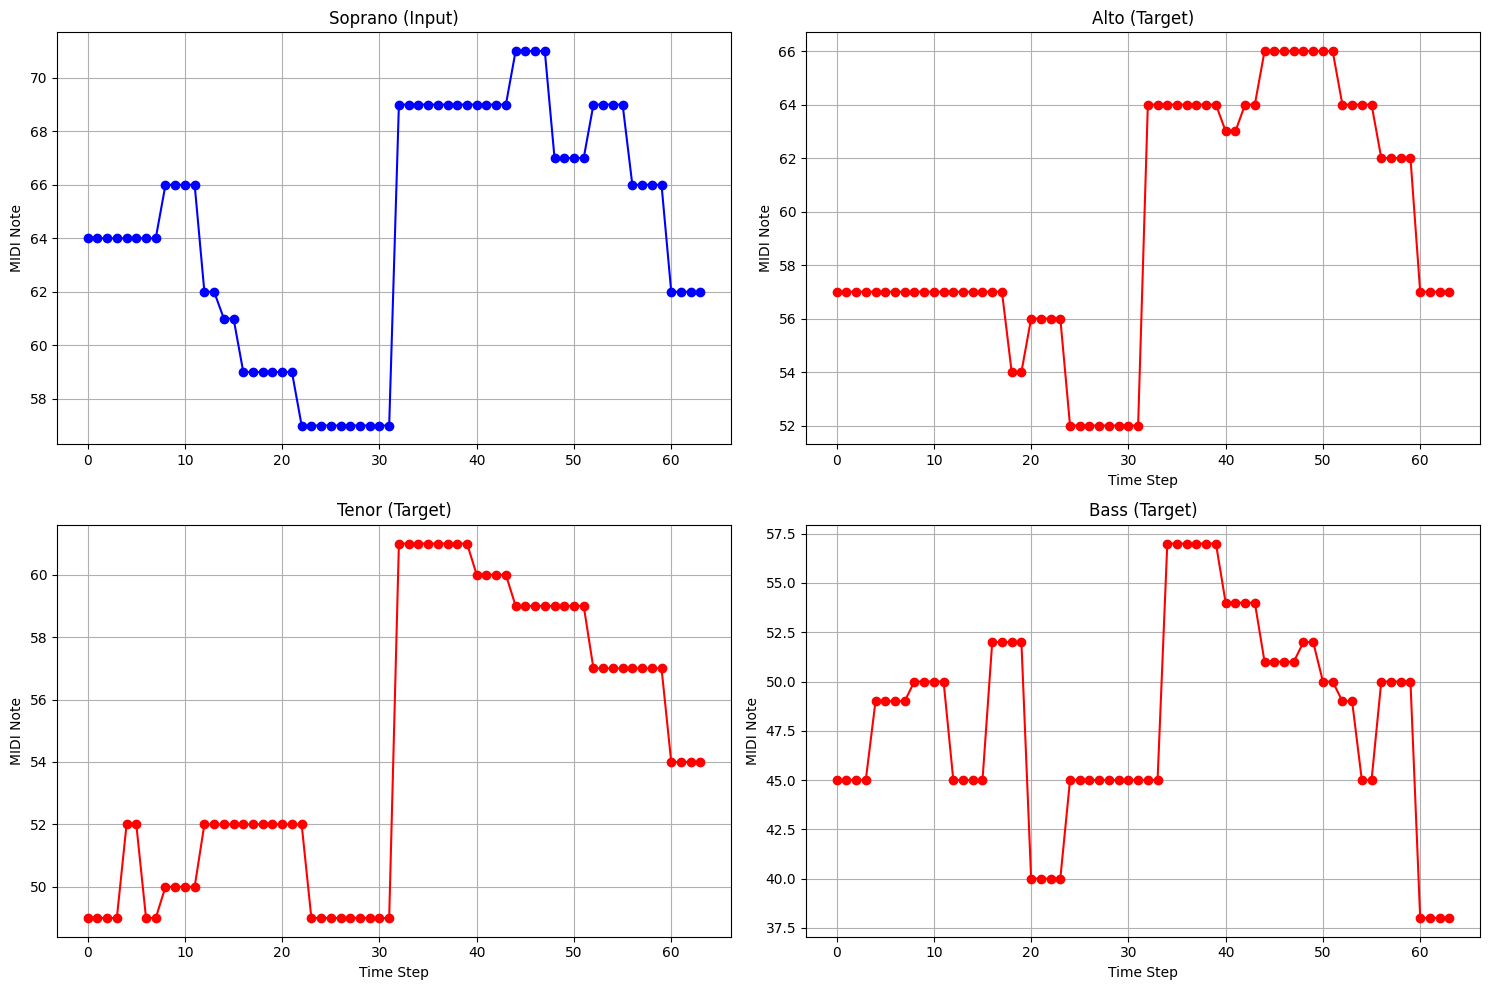

Sample sequence statistics:
  Soprano range: 57 - 71
  Unique notes: 9


In [10]:
visualize_training_data(train_loader)


In [ ]:
def save_processed_data():
    """Save the processed datasets for later use"""
    
    processed_data = {
        'train_dataset': train_dataset,
        'test_dataset': test_dataset, 
        'valid_dataset': valid_dataset,
        'voice_ranges': VOICE_RANGES,
        'config': {
            'sequence_length': SEQUENCE_LENGTH,
            'batch_size': BATCH_SIZE,
            'silence_index': SILENCE_INDEX
        }
    }
    
    torch.save(processed_data, './data/processed_training_data.pt')
    print("Processed data saved to './data/processed_training_data.pt'")

save_processed_data()

💾 Processed data saved to './data/processed_training_data.pt'


🔧 Training device: cpu

📋 Model Architecture Summary:
   Parameters: 1,866,584
   Trainable parameters: 1,866,584
🚀 Harmonization trainer initialized:
  Device: cpu
  Learning rate: 0.001
  Optimization: Adam with weight decay
  Scheduler: ReduceLROnPlateau

🚀 Starting harmonization training...

🎼 Starting Bach Harmonization Training
   Epochs: 10
   Training batches: 8208
   Validation batches: 65

🎵 Training Epoch 1
  Batch   0/8208 | Loss: 10.6856 | LR: 0.001000
  Batch  10/8208 | Loss: 10.6794 | LR: 0.001000
  Batch  20/8208 | Loss: 10.6521 | LR: 0.001000
  Batch  30/8208 | Loss: 10.6509 | LR: 0.001000
  Batch  40/8208 | Loss: 10.6275 | LR: 0.001000
  Batch  50/8208 | Loss: 10.5881 | LR: 0.001000
  Batch  60/8208 | Loss: 10.6380 | LR: 0.001000
  Batch  70/8208 | Loss: 10.4647 | LR: 0.001000
  Batch  80/8208 | Loss: 10.5907 | LR: 0.001000
  Batch  90/8208 | Loss: 10.6495 | LR: 0.001000
  Batch 100/8208 | Loss: 10.5036 | LR: 0.001000
  Batch 110/8208 | Loss: 10.5924 | LR: 0.001000
  

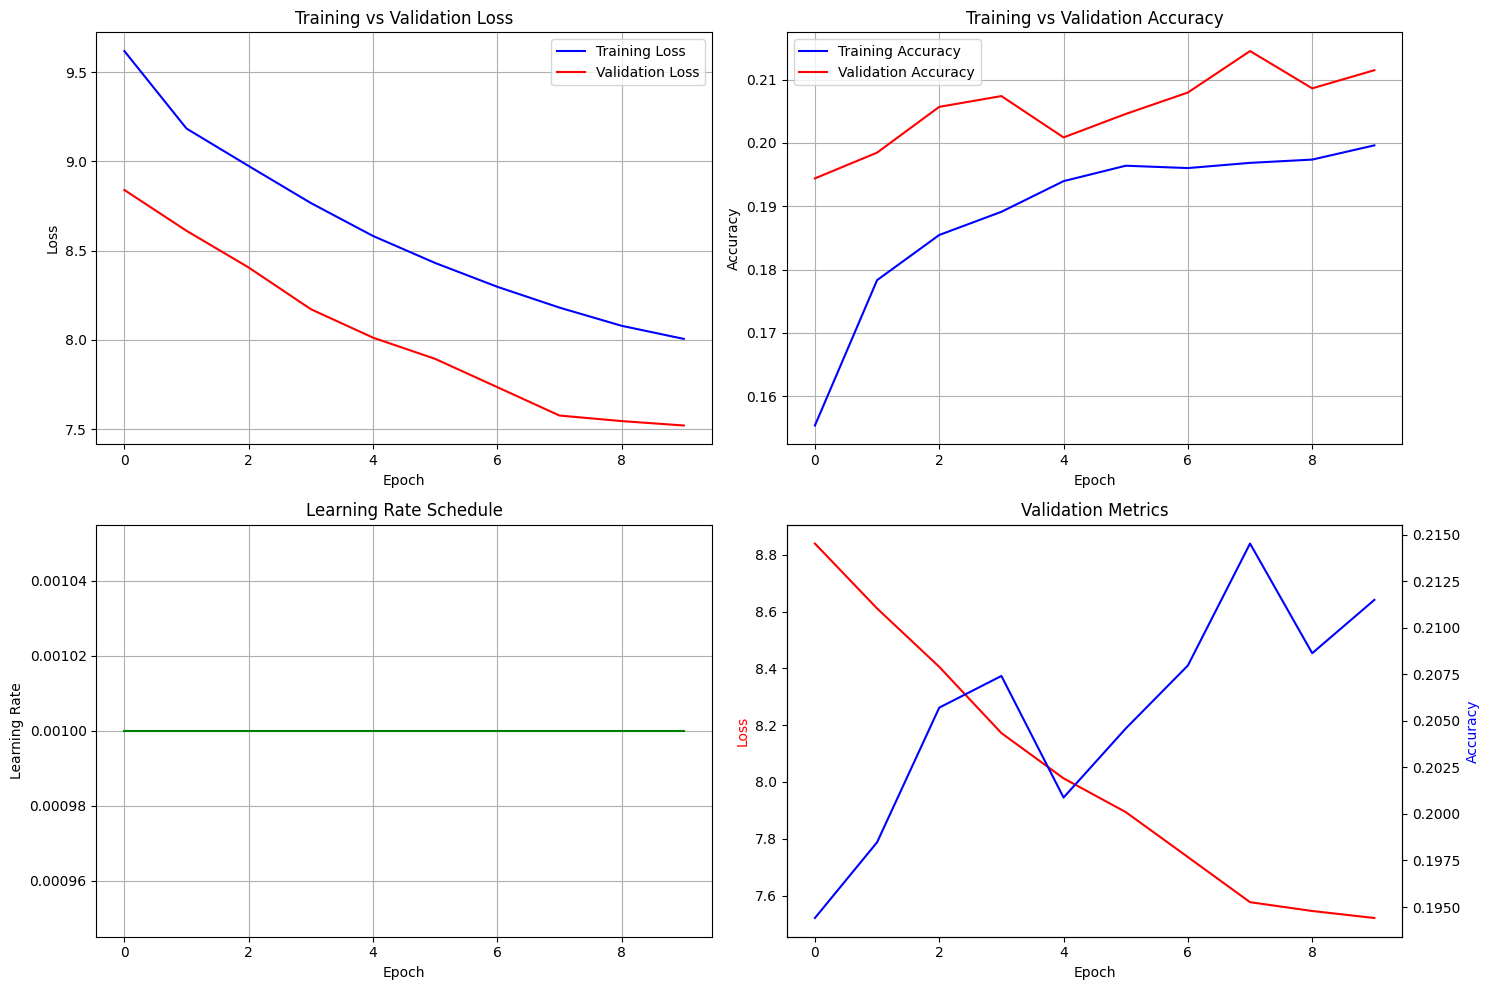


🎼 Bach Chorale Harmonization Training Complete!
💾 Best model saved to: ./models/best_harmonization_model.pt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Training device: {device}")

input_dimensions = SEQUENCE_LENGTH * VOICE_RANGES['soprano'].range_and_silence_length()
harmonization_model = MultiVoiceHarmonizationNetwork(
    input_dimensions=input_dimensions,
    hidden_layer_size=256,
    dropout_rate=0.4
)

print(f"\n📋 Model Architecture Summary:")
print(f"   Parameters: {sum(p.numel() for p in harmonization_model.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in harmonization_model.parameters() if p.requires_grad):,}")

trainer = HarmonizationTrainer(
    model=harmonization_model,
    train_loader=train_loader,
    validation_loader=valid_loader,
    test_loader=test_loader,
    learning_rate=0.001,
    device=device
)

print(f"\n🚀 Starting harmonization training...")
trainer.execute_training(num_epochs=10) 
trainer.plot_training_progress()

print(f"\n🎼 Bach Chorale Harmonization Training Complete!")
print(f"💾 Best model saved to: ./models/best_harmonization_model.pt")

In [1]:
from generate import *

In [11]:
run_midi_generation(test_loader)

🔧 Using device: cpu
✅ Model loaded successfully from ./models/best_harmonization_model.pt
📊 Model has 1,866,584 parameters
🎵 Starting MIDI generation...
Generating 5 MIDI files...

Generating song 1/5
Created track for Soprano with 15 notes
Created track for Alto with 20 notes
Created track for Tenor with 21 notes
Created track for Bass with 18 notes
MIDI file saved: generated_midi/harmony_song_001.mid
Created track for Soprano with 15 notes
MIDI file saved: generated_midi/melody_song_001.mid

Generating song 2/5
Created track for Soprano with 19 notes
Created track for Alto with 15 notes
Created track for Tenor with 19 notes
Created track for Bass with 17 notes
MIDI file saved: generated_midi/harmony_song_002.mid
Created track for Soprano with 19 notes
MIDI file saved: generated_midi/melody_song_002.mid

Generating song 3/5
Created track for Soprano with 15 notes
Created track for Alto with 13 notes
Created track for Tenor with 18 notes
Created track for Bass with 22 notes
MIDI file s

MultiVoiceHarmonizationNetwork(
  (input): Linear(in_features=2112, out_features=200, bias=True)
  (hidden1): Linear(in_features=200, out_features=200, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (hidden2): Linear(in_features=200, out_features=200, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (forward_alto): Linear(in_features=200, out_features=2112, bias=True)
  (forward_tenor): Linear(in_features=200, out_features=2112, bias=True)
  (forward_bass): Linear(in_features=200, out_features=2560, bias=True)
)